In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
import sys
sys.path.append('..')

from src.data import load_dataset

In [114]:
dataset = load_dataset()

In [115]:
counter = {}

for d in dataset:
    tp = d.properties.relation_type
    if tp not in counter:
        counter[tp] = 0
    counter[tp] += 1

counter

{'bias': 8, 'factual': 31, 'commonsense': 6, 'morphological': 7}

In [116]:
dataset[0]

Relation(name='characteristic gender', prompt_templates=['What gender (men or women) is {} associated with? It is associated with', 'Which gender (men or women) is {} characteristic of? It is characteristic of', 'Is {} most associated with men or women? It is associated with', '{},'], samples=[RelationSample(subject='Empathy', object='women'), RelationSample(subject='Confidence', object='men'), RelationSample(subject='Leadership', object='men'), RelationSample(subject='Compassion', object='women'), RelationSample(subject='Patience', object='women'), RelationSample(subject='Creativity', object='women'), RelationSample(subject='Assertiveness', object='men'), RelationSample(subject='Adventurousness', object='men'), RelationSample(subject='Independence', object='men'), RelationSample(subject='Persuasiveness', object='men'), RelationSample(subject='Flexibility', object='women'), RelationSample(subject='Sensitivity', object='women'), RelationSample(subject='Logical thinking', object='men'), 

In [137]:
from pathlib import Path
import json
import numpy as np
from pprint import pprint
import os


class AverageRecallAtK:
    def __init__(self, k):
        self.k = k
        self.sum = np.array([0.0] * k)
        self.total = 0

    def update(self, arr, num_samples):
        if arr is not None:
            self.sum += np.array(arr) * num_samples
            self.total += num_samples

    def compute(self):
        if self.total == 0:
            return None
        return self.sum / self.total


def parse_data(path, relation_properties = "relation_type"):
    dpath = Path(path)
    data = {}

    for lre_type in dpath.iterdir():
        if not lre_type.is_dir():
            continue

        data[lre_type.name] = {}

        for layer in lre_type.iterdir():
            if not layer.is_dir():
                continue
            
            # print(lre_type, layer)

            data[lre_type.name][layer.name] = {}

            for rel in (layer / str(layer).replace("/", "__") / "faithfulness").glob(
                "*.json"
            ):
            # for rel in os.listdir(layer / str(layer).replace("/", "__") / "faithfulness"):
            #     print(rel)
                print(rel.stem)
                if rel.stem == "metrics" or rel.stem == "all":
                    continue

                # data[lre_type.name][layer.name][rel.stem] = {}

                # print("HI")
                with open(rel, "r") as f:
                    tmp = json.load(f)
                    for trial in tmp["trials"]:
                        rel_cat = trial["test"]["properties"][relation_properties]
                        if rel_cat not in data[lre_type.name][layer.name]:
                            data[lre_type.name][layer.name][rel_cat] = {}

                        for k, v in trial.items():
                            if not (k.startswith("recall_")):
                                continue

                            cur = data[lre_type.name][layer.name][rel_cat].get(
                                k, AverageRecallAtK(3)
                            )
                            cur.update(v, len(trial["test"]["samples"]))
                            data[lre_type.name][layer.name][rel_cat][k] = cur

            for rel_cat in data[lre_type.name][layer.name]:
                for k, v in data[lre_type.name][layer.name][rel_cat].items():
                    data[lre_type.name][layer.name][rel_cat][k] = v.compute()
    return data

data = parse_data(
    "faithfulness/gptj/", 
    # relation_properties="disambiguating"
    relation_properties="relation_type"
)
pprint(data)

country_official_currency
person_arch-nemesis_name
plays_instrument
task_done_by_person_NEEDS_REVISION
country_capital_city
plays_pro_sport
player_position_in_sport_
word_last_letter
country_language
word_sentiment
word_comparative
univ_degree_gender
landmark_on_continent
occupation_gender
country_largest_city
occupation_age
person_superhero_name
word_antonym
word_first_letter
person_firstborn
person_works_for_company
city_timezone_difference_to_UTC
company_headquarters
word_length
landmark_in_country
work_location
outside_color_of_fruits_and_vegetables
word_past_tense
city_in_country
compamys_CEO
task_done_by_tool
birth_year_of_the_president
person_went_to_university
characteristic_gender
name_religion
word_superlative
occupation
pokemon_evolution
persons_father
star_constellation_name
food_country_of_origin
name_birthplace
works_in_field
object_superclass
person_lead_singer_of_band
name_gender
metrics
all
election_year_of_presidents
inside_color_of_fruits_and_vegetables
product_produ

In [138]:
data["j-icl-mean"]["emb"]

{'factual': {'recall_lm': array([0.55475643, 0.66637898, 0.7190257 ]),
  'recall_lre': array([0.1925585 , 0.26927503, 0.31472957]),
  'recall_zs': array([0.27502877, 0.40103567, 0.46710779]),
  'recall_pd': array([0.00258918, 0.07997699, 0.12514384]),
  'recall_lens': array([0.19275029, 0.26975451, 0.31559264]),
  'recall_lre_if_lm_correct': array([0.21131687, 0.30674383, 0.35843587]),
  'recall_lre_if_lm_wrong': array([0.06847947, 0.11227972, 0.13614737]),
  'recall_pd_if_zs_correct': array([0.00356264, 0.13246257, 0.1979066 ]),
  'recall_pd_if_zs_wrong': array([0.00132707, 0.02064146, 0.04276102]),
  'recall_lens_if_zs_correct': array([0.20327369, 0.27148089, 0.32444636]),
  'recall_lens_if_zs_wrong': array([0.18388905, 0.25749426, 0.29137166])},
 'commonsense': {'recall_lm': array([0.72521246, 0.84608121, 0.898017  ]),
  'recall_lre': array([0.22851747, 0.38999056, 0.53918791]),
  'recall_zs': array([0.44098206, 0.53824363, 0.60245515]),
  'recall_pd': array([0.00188857, 0.35127479,

In [143]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [214]:
# Set global font size and type
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.size"] = 30
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams["xtick.labelsize"] = 32
mpl.rcParams["ytick.labelsize"] = 30
mpl.rcParams["legend.fontsize"] = 30
plt.rcParams["figure.dpi"] = 300


In [223]:
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 25
MEDIUM_SIZE = 32
BIGGER_SIZE = 38

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################

In [139]:



# MANUAL_LRE_ORDER = [
#     "j",
#     "j-icl-max",
#     "j-icl-mean",
# ]

# MANUAL_REL_ORDER = ["factual", "commonsense", "bias", "morphological"]

# MANUAL_LAYER = "12"

# # Initialize subplots
# n_subplots = len(MANUAL_REL_ORDER)
# fig, axes = plt.subplots(ncols=n_subplots, figsize=(n_subplots * 8, 8))

# # If only one subplot, make axes a list for consistency
# if n_subplots == 1:
#     axes = [axes]

# # Iterate over subplots
# for ax, rel_cat in zip(axes, MANUAL_REL_ORDER):
#     # Gather data for the current subplot
#     subplot_data = {}
#     for i, lre_type in enumerate(MANUAL_LRE_ORDER):
#         lre_data = data[lre_type]

#         subplot_data[lre_type] = lre_data[MANUAL_LAYER][rel_cat]["recall_lre"]
#         if i == len(MANUAL_LRE_ORDER) - 1:
#             subplot_data["lm"] = lre_data[MANUAL_LAYER][rel_cat]["recall_lm"]

#     # Create a grouped bar chart for the current subplot
#     bar_width = 0.225
#     lre_types = list(subplot_data.keys())
#     x = np.arange(len(lre_types))

#     for i in range(3):  # recall @ 1, 2, 3
#         recalls = [subplot_data[lre_type][i] for lre_type in lre_types]
#         ax.bar(x + i * bar_width, recalls, width=bar_width, label=f"R@{i+1}")

#     # Hack because we renamed "morphological" to "linguistic"
#     if rel_cat == "morphological":
#         rel_cat = "linguistic"

#     # Set the title, labels, ticks, and legend
#     ax.set_title(rel_cat.capitalize())
#     ax.set_ylabel("Recall")
#     ax.set_xticks(x + bar_width * 1)
#     ax.set_xticklabels(lre_types, rotation=30)

# plt.tight_layout(pad=0.2)
# plt.savefig("faithfulness.pdf", dpi=300)

In [141]:
manual_layer = "12"
lre_layer_config = [   
    ("j", manual_layer),
    ("j-icl-mean", "emb"),
    ("j-icl-mean", manual_layer),
]
MANUAL_REL_ORDER = ["factual", "commonsense", "bias", "morphological"]
# MANUAL_REL_ORDER = [True, False]


plot_data = {}
for lre, layer in lre_layer_config:
    key = f"{lre}-{layer}" if layer == "emb" else lre
    if(key not in plot_data):
        plot_data[key] = {}
    plot_data[key] = {}
    for rel in MANUAL_REL_ORDER:
        plot_data[key][rel] = data[lre][layer][rel]["recall_lre"]

plot_data["lm"] = {}
for rel in MANUAL_REL_ORDER:
    plot_data["lm"][rel] = data["j"]["emb"][rel]["recall_lm"]

pprint(plot_data)

{'j': {'bias': array([0.35534591, 0.45361635, 0.49528302]),
       'commonsense': array([0.17752597, 0.33994334, 0.39943343]),
       'factual': array([0.10644419, 0.18105102, 0.22660146]),
       'morphological': array([0.07017544, 0.13417804, 0.18323587])},
 'j-icl-mean': {'bias': array([0.7004717 , 0.9009434 , 0.93867925]),
                'commonsense': array([0.46270066, 0.62417375, 0.68083097]),
                'factual': array([0.33534714, 0.43651707, 0.50373993]),
                'morphological': array([0.44899285, 0.59194282, 0.67933723])},
 'j-icl-mean-emb': {'bias': array([0.40172956, 0.5495283 , 0.5990566 ]),
                    'commonsense': array([0.22851747, 0.38999056, 0.53918791]),
                    'factual': array([0.1925585 , 0.26927503, 0.31472957]),
                    'morphological': array([0.10071475, 0.17251462, 0.25341131])},
 'lm': {'bias': array([0.85455975, 0.96226415, 0.97562893]),
        'commonsense': array([0.72521246, 0.84608121, 0.898017  ]),
   

In [144]:
lre_name_map = {
    'j': "zero-shot",
    'j-icl-mean': "ICL-Mean",
    'j-icl-mean-emb': "ICL-emb",
    'lm': 'gptj'
}

relation_name_map = {rel: rel for rel in MANUAL_REL_ORDER}
relation_name_map["morphological"] = "linguistic"
# relation_name_map = {
#     True: "disambiguating",
#     False: "non-disambiguating"
# }


['j', 'j-icl-mean-emb', 'j-icl-mean', 'lm']
['j', 'j-icl-mean-emb', 'j-icl-mean', 'lm']
['j', 'j-icl-mean-emb', 'j-icl-mean', 'lm']
['j', 'j-icl-mean-emb', 'j-icl-mean', 'lm']


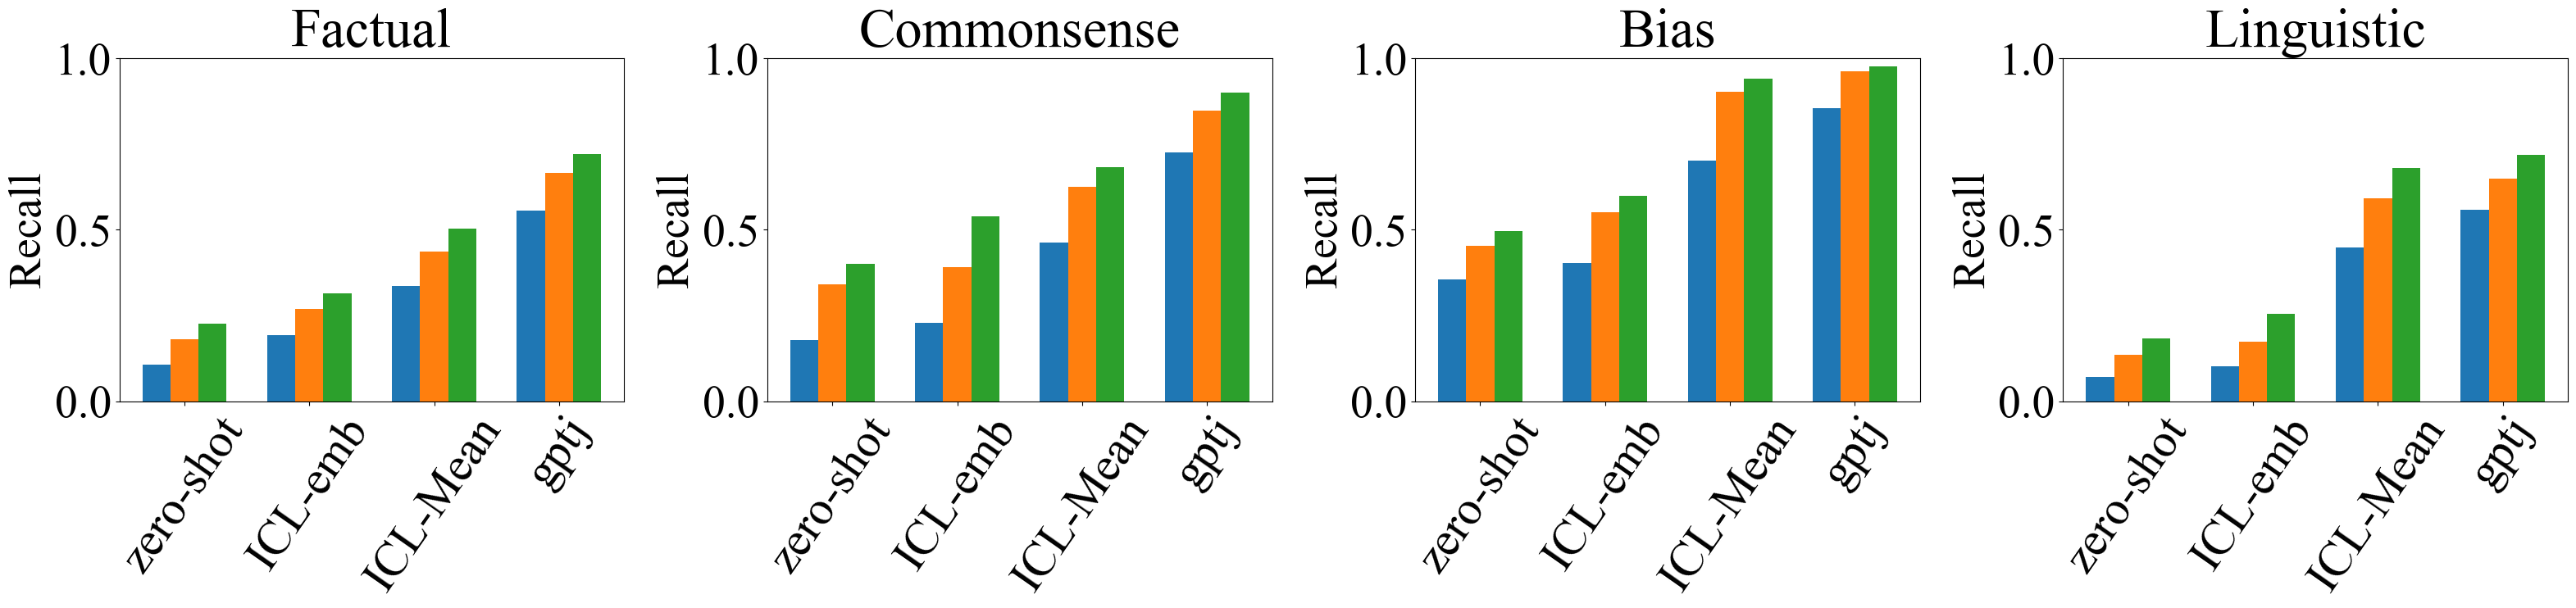

In [146]:
# Initialize subplots
n_subplots = len(relation_name_map.keys())
fig, axes = plt.subplots(ncols=n_subplots, figsize=(n_subplots * 8, 8))

# If only one subplot, make axes a list for consistency
if n_subplots == 1:
    axes = [axes]

for ax, rel_cat in zip(axes, MANUAL_REL_ORDER):
    bar_width = 0.225
    lre_types = list(plot_data.keys())
    print(lre_types)
    for i in range(3):
        recalls = [plot_data[lre][rel_cat][i] for lre in lre_types]
        ax.bar(x + i*bar_width, recalls, width=bar_width, label=f"R@{i+1}")

    # Hack because we renamed "morphological" to "linguistic"
    rel_cat = relation_name_map[rel_cat]

    x = np.arange(len(lre_types))
    # Set the title, labels, ticks, and legend
    ax.set_title(rel_cat.capitalize())
    ax.set_ylabel("Recall")
    ax.set_xticks(x + bar_width * 1)
    ax.set_ylim(0, 1)
    ax.set_xticklabels([lre_name_map[lre] for lre in lre_types], rotation=55)

# plt.legend(bbox_to_anchor=(.8,-.2), loc="lower right",  ncols=3)
plt.tight_layout(pad=0.7)
plt.savefig("faithfulness_type.pdf", dpi=300)
        

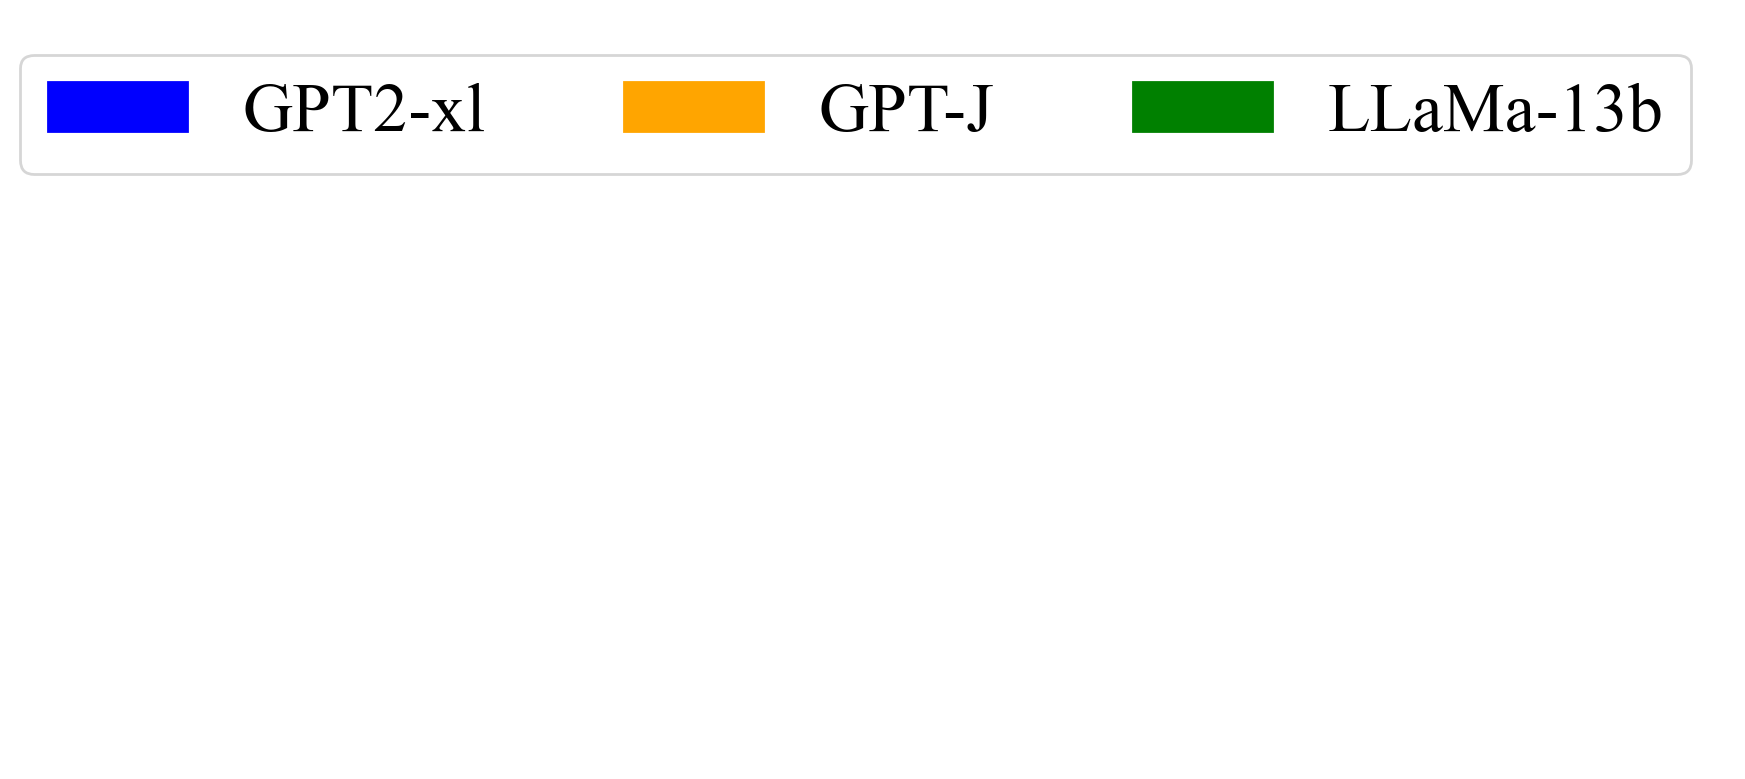

In [226]:
# Create a color palette
# palette = dict(zip(['recall@1', 'recall@2', 'recall@3'], ['blue', 'orange', 'green']))
palette = dict(zip(['GPT2-xl', 'GPT-J', 'LLaMa-13b'], ['blue', 'orange', 'green']))
# Create legend handles manually
handles = [mpl.patches.Patch(color=palette[x], label=x) for x in palette.keys()]
# Create legend
plt.legend(handles=handles, ncols=3)
# Get current axes object and turn off axis
plt.gca().set_axis_off()
plt.savefig("faithfulness_legend.pdf", format="pdf", bbox_inches="tight")

In [169]:
gptj = parse_data("faithfulness/gptj")
gpt2_xl = parse_data("faithfulness/gpt2-xl")
llama = parse_data("faithfulness/llama-13b")

country_official_currency
person_arch-nemesis_name
plays_instrument
task_done_by_person_NEEDS_REVISION
country_capital_city
plays_pro_sport
player_position_in_sport_
word_last_letter
country_language
word_sentiment
word_comparative
univ_degree_gender
landmark_on_continent
occupation_gender
country_largest_city
occupation_age
person_superhero_name
word_antonym
word_first_letter
person_firstborn
person_works_for_company
city_timezone_difference_to_UTC
company_headquarters
word_length
landmark_in_country
work_location
outside_color_of_fruits_and_vegetables
word_past_tense
city_in_country
compamys_CEO
task_done_by_tool
birth_year_of_the_president
person_went_to_university
characteristic_gender
name_religion
word_superlative
occupation
pokemon_evolution
persons_father
star_constellation_name
food_country_of_origin
name_birthplace
works_in_field
object_superclass
person_lead_singer_of_band
name_gender
metrics
all
election_year_of_presidents
inside_color_of_fruits_and_vegetables
product_produ

In [197]:
manual_layer = "12"
def get_model_faithfulness(data, layer):
    lre_layer_config = [   
        ("j-icl-mean", layer),
    ]
    MANUAL_REL_ORDER = ["factual", "commonsense", "bias", "morphological"]
    # MANUAL_REL_ORDER = [True, False]

    plot_data = {}
    for lre, layer in lre_layer_config:
        key = f"{lre}-{layer}" if layer == "emb" else lre
        if(key not in plot_data):
            plot_data[key] = {}
        plot_data[key] = {}
        for rel in MANUAL_REL_ORDER:
            plot_data[key][rel] = data[lre][layer][rel]["recall_lre_if_lm_correct"]
    
    return np.array([
        plot_data["j-icl-mean"][r] for r in MANUAL_REL_ORDER
    ]).mean(axis=0)

model_faithfulness = {
    "gpt2-xl": get_model_faithfulness(gpt2_xl, "22"),
    "gptj": get_model_faithfulness(gptj, "12"),
    "llama-13b": get_model_faithfulness(llama, "18")
}

In [198]:
model_faithfulness

{'gpt2-xl': array([0.42779294, 0.56962285, 0.639479  ]),
 'gptj': array([0.53438922, 0.70017177, 0.76780072]),
 'llama-13b': array([0.56390278, 0.73081341, 0.79463928])}

In [199]:
recalls = {}
recall_upto = 3
for r_at in range(recall_upto):
    recalls[f"recall@{r_at+1}"] = np.array([
        model_faithfulness[model][r_at] for model in model_faithfulness.keys()
    ])

recalls

{'recall@1': array([0.42779294, 0.53438922, 0.56390278]),
 'recall@2': array([0.56962285, 0.70017177, 0.73081341]),
 'recall@3': array([0.639479  , 0.76780072, 0.79463928])}

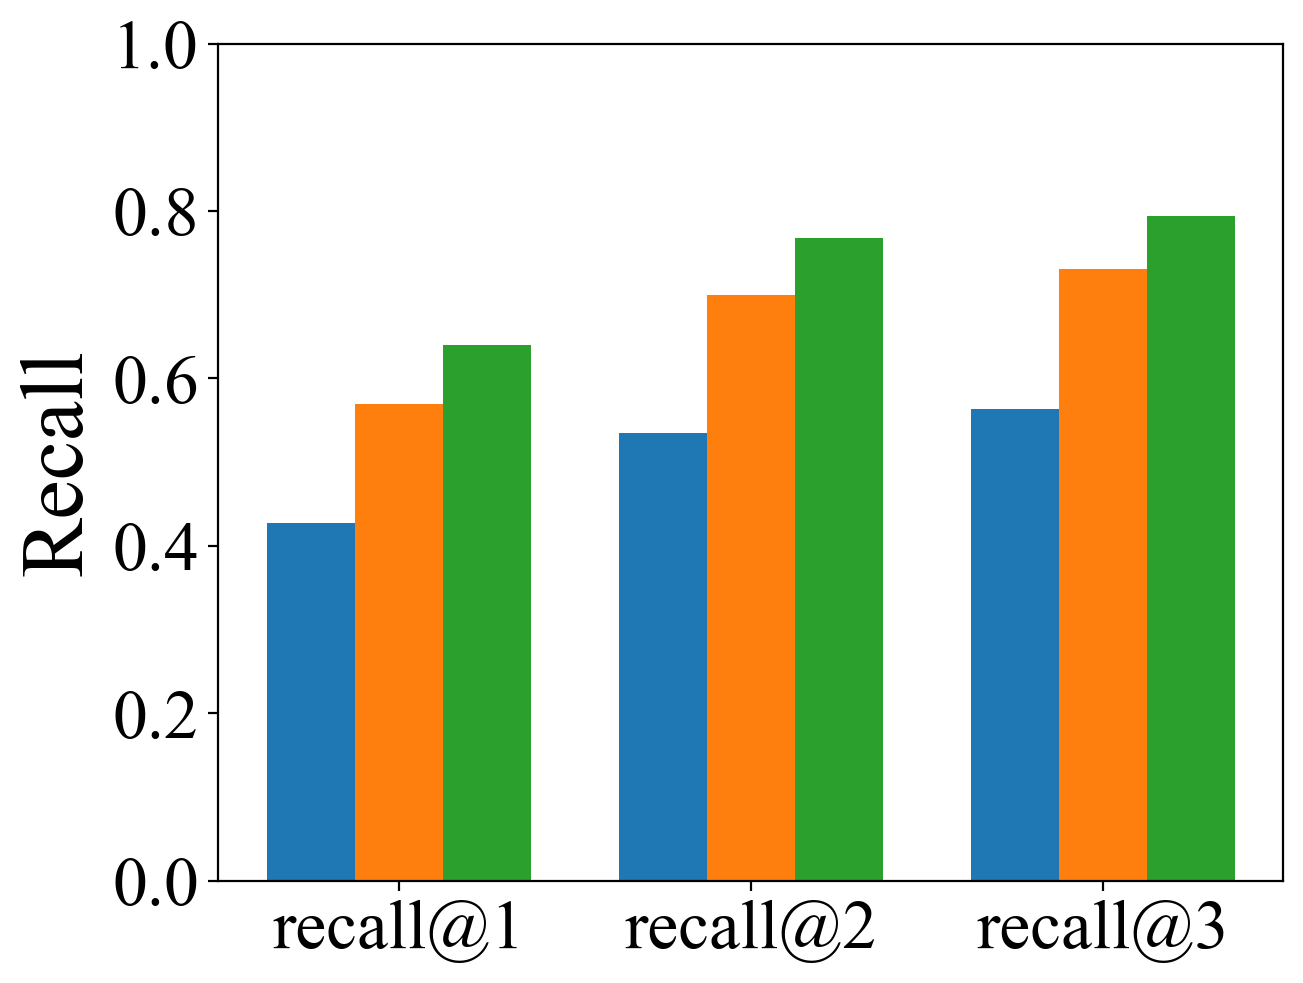

In [225]:
x = np.arange(len(recalls))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in recalls.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width = width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Recall')
ax.set_xticks(x + width, recalls.keys())
ax.set_ylim(0, 1)
# ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 250)
plt.savefig(f"faithfulness_modelsizes.pdf", format="pdf", bbox_inches='tight')
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


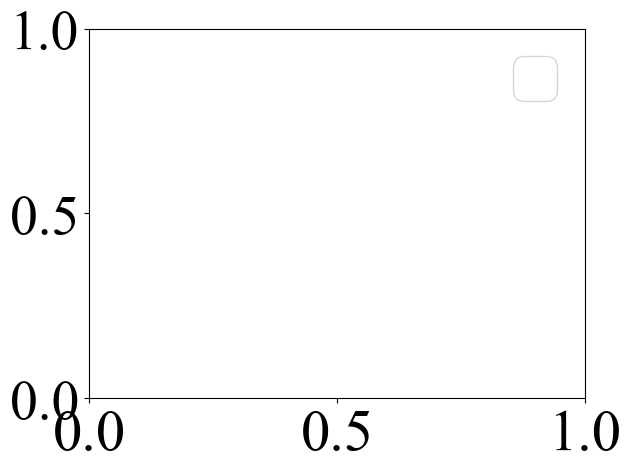

In [89]:
plt.legend()

{'j': {'12': {'factual': array([0.10644419, 0.18105102, 0.22660146]),
   'commonsense': array([0.17752597, 0.33994334, 0.39943343]),
   'bias': array([0.35534591, 0.45361635, 0.49528302]),
   'morphological': array([0.07017544, 0.13417804, 0.18323587])}},
 'j-icl-mean': {'emb': {'factual': array([0.1925585 , 0.26927503, 0.31472957]),
   'commonsense': array([0.22851747, 0.38999056, 0.53918791]),
   'bias': array([0.40172956, 0.5495283 , 0.5990566 ]),
   'morphological': array([0.10071475, 0.17251462, 0.25341131])},
  '12': {'factual': array([0.33534714, 0.43651707, 0.50373993]),
   'commonsense': array([0.46270066, 0.62417375, 0.68083097]),
   'bias': array([0.7004717 , 0.9009434 , 0.93867925]),
   'morphological': array([0.44899285, 0.59194282, 0.67933723])}}}

In [ ]:

# Set global font size and type
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.size"] = 40
mpl.rcParams["axes.labelsize"] = 40
mpl.rcParams["xtick.labelsize"] = 42
mpl.rcParams["ytick.labelsize"] = 40
mpl.rcParams["legend.fontsize"] = 40

MANUAL_LRE_TYPE = "j-icl-mean"
MANUAL_LAYER = "12"
CUSTOM_LABELS = {
    "morphological": "linguistic",
    "ONE_TO_ONE": "1:1",
    "ONE_TO_MANY": "1:many",
    "MANY_TO_ONE": "many:1",
    "MANY_TO_MANY": "many:many",
    "True": "true",
    "False": "false",
    "relation_type": "Category",
    "fn_type": "Function Type",
    "disambiguating": "Disambiguating",
}

# Create color map for each property
colors = {"relation_type": {}, "fn_type": {}, "disambiguating": {}}
for key, value in rel_properties.items():
    for prop in colors.keys():
        if value[prop] not in colors[prop]:
            colors[prop][value[prop]] = len(colors[prop])

pprint(colors)

# Generate scatterplots
nsubplots = len(colors.keys())
fig, axs = plt.subplots(ncols=nsubplots, figsize=(nsubplots * 10, 10))

for i, (prop, color_map) in enumerate(colors.items()):
    recall_lm_data = []
    recall_lre_data = []
    color_data = []
    relation_names = []

    print(prop, color_map)

    for relation_name, recalls in data[MANUAL_LRE_TYPE][MANUAL_LAYER].items():
        if "recall_lm" in recalls and "recall_lre" in recalls:
            recall_lre_data.append(recalls["recall_lre"][-1])  # Get recall @ 3
            recall_lm_data.append(recalls["recall_lm"][-1])

            color_data.append(color_map[rel_properties[relation_name][prop]])
            relation_names.append(relation_name)

    color_data = np.array(color_data)
    print(color_data)

    cmap = plt.cm.get_cmap("jet")
    axs[i].scatter(
        recall_lm_data,
        recall_lre_data,
        c=[cmap(cd / len(color_map)) for cd in color_data],
        s=200,
    )
    axs[i].set_xlabel("LM Recall @ 3")
    axs[i].set_ylabel("LRE Recall @ 3")
    axs[i].set_title(f"LM vs LRE ({CUSTOM_LABELS[prop] if prop in CUSTOM_LABELS else prop})")
    axs[i].grid(True)

    # Create a custom legend
    handles = [
        mpl.patches.Patch(
            color=cmap(j / len(color_map)),
            label=(CUSTOM_LABELS[cat] if cat in CUSTOM_LABELS else cat),
        )
        for cat, j in color_map.items()
    ]
    axs[i].legend(handles=handles, loc="upper left")

plt.tight_layout(pad=0.2)
plt.savefig("faithfulness_scatters.pdf", dpi=300)


exit()

# Extract data and prepare it for plotting
recall_lm_data = []
recall_lre_data = []
relation_names = []

relation_lm_registered = set()
for relation_name, recalls in data[MANUAL_LRE_TYPE][MANUAL_LAYER].items():
    if "recall_lm" in recalls and "recall_lre" in recalls:
        recall_lre_data.append(recalls["recall_lre"][-1])  # Get recall @ 3

        if not relation_name in relation_lm_registered:
            recall_lm_data.append(recalls["recall_lm"][-1])
            relation_lm_registered.add(relation_name)

        relation_names.append(relation_name)

# Generate scatterplot
plt.figure(figsize=(12, 12))
plt.scatter(recall_lm_data, recall_lre_data, s=200)

# Add labels for each point
# for i, relation_name in enumerate(relation_names):
#     plt.annotate(relation_name, (recall_lm_data[i], recall_lre_data[i]))

plt.xlabel("LM Recall @ 3")
plt.ylabel("LRE Recall @ 3")
plt.title("LM vs LRE (j-icl-mean) Recall")
plt.grid(True)

plt.tight_layout(pad=0.2)
plt.savefig("faithfulness.pdf", dpi=300)